## Large Data Limits paper
This is just a rough first version, not entirely true to what it should be. 

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from openTSNE import TSNE

In [3]:
def run_rescaled_tsne(data, kappa=30, alpha=0.1):
    """
    Run t-SNE with a rescaled perplexity and exaggeration factor.

    Parameters:
      - data: ndarray of shape (n_samples, n_features)
      - kappa: base constant (effective number of neighbors)
      - alpha: exponent to allow perplexity to grow as n^alpha
      
    Returns:
      - embedding: 2D embedding from t-SNE.
    """
    n, d = data.shape
    # Note: b(=20 here) needs to be larger than 1/d 
    b = 20 
    h_n = n ** (-1/b)
    # Perplexity should be chosen to scale slowly with n.
    scaled_perplexity = kappa * (n ** alpha)
    # Early exaggeration factor: rescale the attractive term by 1/h_n^2.
    exaggeration = 1 / (h_n ** 2)
    
    print(f"n = {n}, d = {d}, b={b}")
    print(f"Computed h_n = {h_n:.4f}")
    print(f"Using perplexity = {scaled_perplexity:.2f} (base κ = {kappa}, exponent α = {alpha})")
    print(f"Using early exaggeration = {exaggeration:.2f}")

    tsne = TSNE(
        perplexity=scaled_perplexity,
        early_exaggeration_iter=250,
        exaggeration=exaggeration,
        initialization="pca",
        n_jobs=-1,
        random_state=42,
    )
    embedding = tsne.fit(data)
    return embedding


In [16]:
def create_synthetic_data(n_points=10000, n_features=50, n_clusters=5, cluster_std=1.0):
    """
    Generate synthetic data as a mixture of Gaussians.
    """
    np.random.seed(42)
    data = []
    labels = []
    centers = np.random.randn(n_clusters, n_features) * 0.7
    points_per_cluster = n_points // n_clusters
    for i in range(n_clusters):
        points = centers[i] + cluster_std * np.random.randn(points_per_cluster, n_features)
        data.append(points)
        labels.append(np.full(points.shape[0], i))
    data = np.vstack(data)
    labels = np.concatenate(labels)

    indices = np.random.permutation(n_points)
    return data[indices], labels[indices]


In [8]:
def run_standard_tsne(data, perplexity=30, exaggeration=12):
    """
    Run standard t-SNE with fixed perplexity and exaggeration.
    """
    tsne = TSNE(
        perplexity=perplexity,
        early_exaggeration_iter=250,
        exaggeration=exaggeration,
        initialization="pca",
        n_jobs=4,
        random_state=42,
    )
    return tsne.fit(data)

## Experiments: Varying Samples Sizes - Comparison rescaled and standard t-SNE

Perplexity value 47 is too high. Using perplexity 33.00 instead


n = 100, d = 50, b=20
Computed h_n = 0.7943
Using perplexity = 47.55 (base κ = 30, exponent α = 0.1)
Using early exaggeration = 1.58


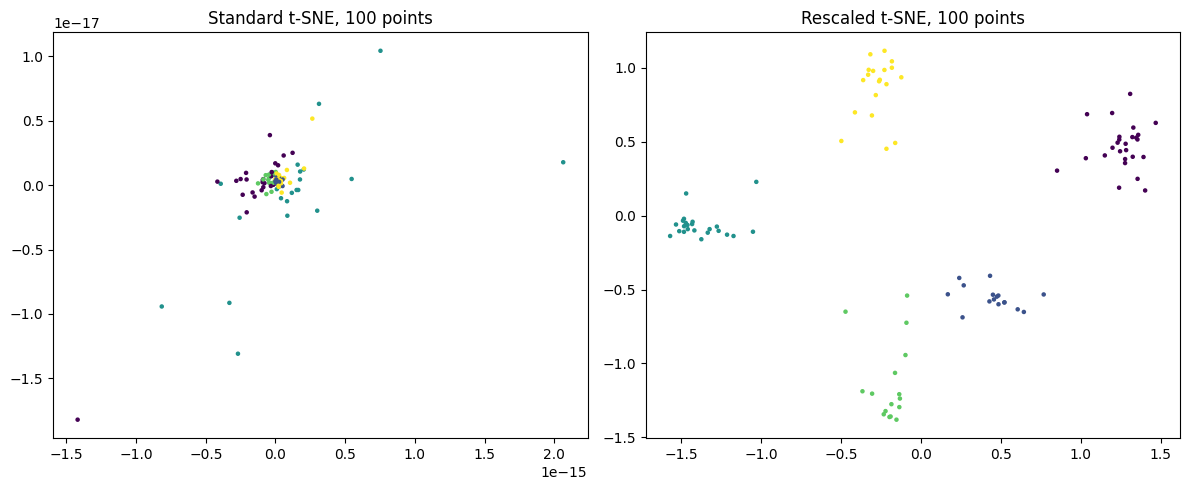

n = 500, d = 50, b=20
Computed h_n = 0.7329
Using perplexity = 55.85 (base κ = 30, exponent α = 0.1)
Using early exaggeration = 1.86


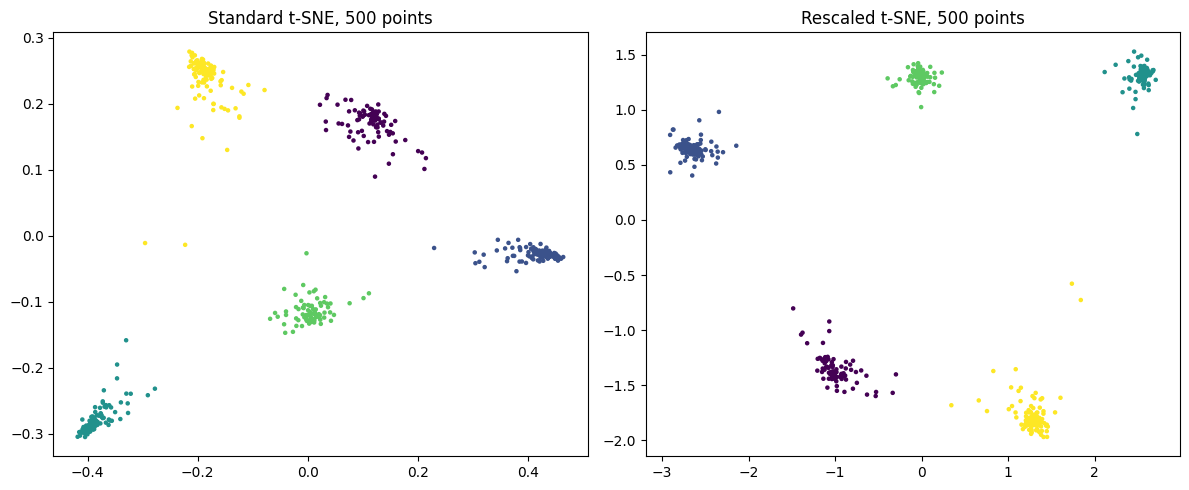

In [ ]:
# Choose a fixed sample size
# data_sizes = [100, 500, 1000, 5000, 10000, 30000]
data_sizes = [100, 500, 1000, 5000]
data_all, labels_all = create_synthetic_data(n_points=30000, n_features=50, n_clusters=5)

for n_fixed in data_sizes: 

    data_subset = data_all[:n_fixed]

    # Standard t-SNE (with constant perplexity and exaggeration)
    emb_standard = run_standard_tsne(data_subset, perplexity=30, exaggeration=12)

    # Rescaled t-SNE (per our new model)
    emb_rescaled = run_rescaled_tsne(data_subset, kappa=30, alpha=0.1)

    # Plot side-by-side
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.scatter(emb_standard[:, 0], emb_standard[:, 1], c=labels_all[:n_fixed], cmap='viridis', s=5)
    plt.title(f"Standard t-SNE, {n_fixed} points")
   
    plt.subplot(1, 2, 2)
    plt.scatter(emb_rescaled[:, 0], emb_rescaled[:, 1], c=labels_all[:n_fixed], cmap='viridis', s=5)
    plt.title(f"Rescaled t-SNE, {n_fixed} points")
   
    plt.tight_layout()
    plt.show()